In [1]:
import wandb
wandb.init(project="visualize-sklearn")

wandb: Currently logged in as: betelegeuse. Use `wandb login --relogin` to force relogin


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

data\mitbih_test.csv
data\mitbih_train.csv
data\ptbdb_abnormal.csv
data\ptbdb_normal.csv


In [3]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")



train_df = pd.read_csv("data/mitbih_train.csv", header=None)
test_df = pd.read_csv("data/mitbih_test.csv", header=None)
train_df.to_numpy()
test_df.to_numpy()

array([[1.        , 0.75826448, 0.11157025, ..., 0.        , 0.        ,
        0.        ],
       [0.90842491, 0.7838828 , 0.53113556, ..., 0.        , 0.        ,
        0.        ],
       [0.73008847, 0.21238938, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.        , 0.96735907, 0.62017804, ..., 0.        , 0.        ,
        4.        ],
       [0.98412699, 0.5674603 , 0.60714287, ..., 0.        , 0.        ,
        4.        ],
       [0.97396964, 0.91323209, 0.86550975, ..., 0.        , 0.        ,
        4.        ]])

In [4]:
from sklearn.model_selection import train_test_split
x = train_df.loc[:,train_df.columns!=187]
y = train_df.loc[:,train_df.columns==187]
test_x = train_df.loc[:,test_df.columns!=187]
test_y = train_df.loc[:,test_df.columns==187]

train_x, val_x, train_y, val_y = train_test_split(x.to_numpy(), y.to_numpy(), test_size = 0.4)
# train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.25)

In [5]:
equilibre = y.value_counts()
print(equilibre)

187
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
dtype: int64


In [6]:
pd.DataFrame(train_y).value_counts()

0.0    43512
4.0     3793
2.0     3483
1.0     1366
3.0      378
dtype: int64

In [7]:
pd.DataFrame(val_y).value_counts()

0.0    28959
4.0     2638
2.0     2305
1.0      857
3.0      263
dtype: int64

In [8]:
print(test_df.loc[:, test_df.columns==187].value_counts())

187
0.0    18118
4.0     1608
2.0     1448
1.0      556
3.0      162
dtype: int64


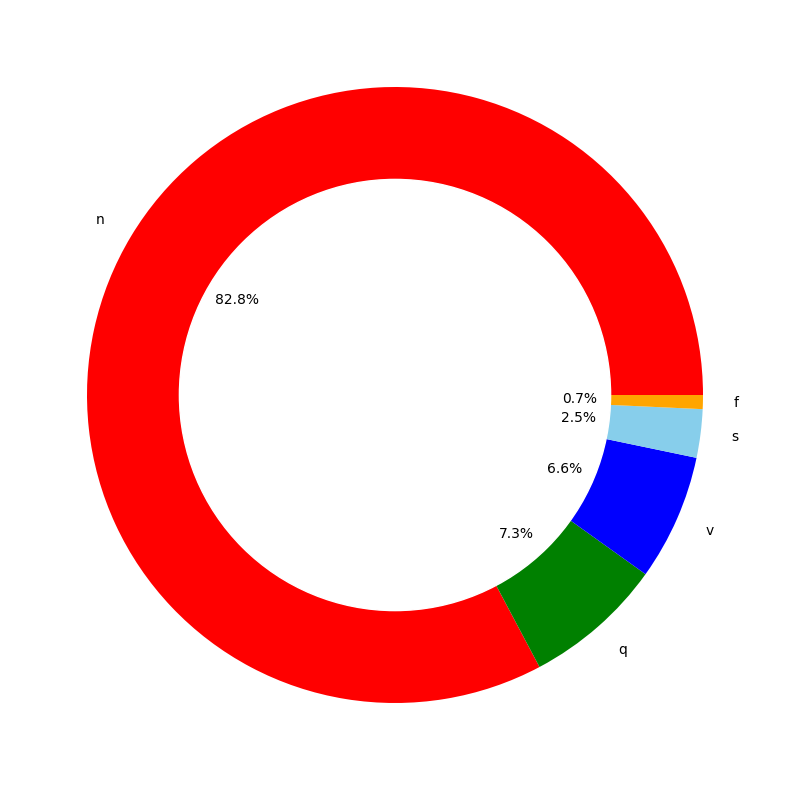

In [9]:
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['n','q','v','s','f'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [10]:
from sklearn.utils import resample
df_1=train_df[train_df[187]==1]
df_2=train_df[train_df[187]==2]
df_3=train_df[train_df[187]==3]
df_4=train_df[train_df[187]==4]
df_0=(train_df[train_df[187]==0]).sample(n=5000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=5000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=5000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=5000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=5000,random_state=126)

train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

In [11]:
equilibre=train_df[187].value_counts()
print(equilibre)

0.0    5000
1.0    5000
2.0    5000
3.0    5000
4.0    5000
Name: 187, dtype: int64


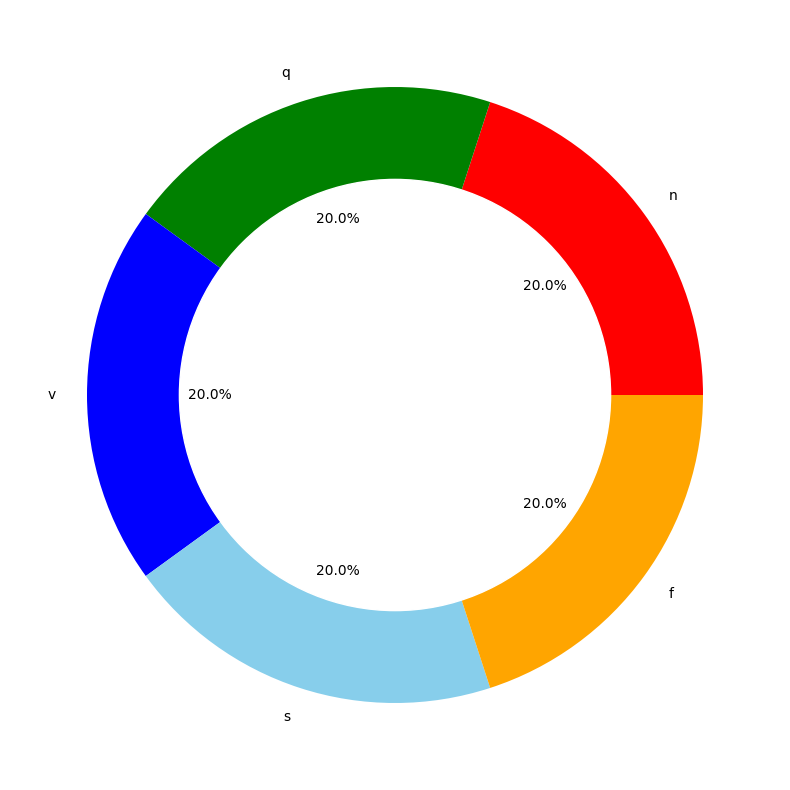

In [12]:
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['n','q','v','s','f'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [13]:
from sklearn.model_selection import train_test_split
x = train_df.loc[:,train_df.columns!=187]
y = train_df.loc[:,train_df.columns==187]

train_x, val_x, train_y, val_y = train_test_split(x.to_numpy(), y.to_numpy(), test_size = 0.4)
print(pd.DataFrame(train_y).value_counts())

0.0    3058
4.0    3022
2.0    3005
1.0    2981
3.0    2934
dtype: int64


In [1]:
from xgboost import XGBClassifier
import xgboost
from wandb.xgboost import wandb_callback

my_model = XGBClassifier(silent=False, 
                        scale_pos_weight=1,
                        learning_rate=0.01,
                        colsample_bytree = 0.4,
                        subsample = 0.8,
                        objective='binary:logistic',
                        n_estimators=1000,
                        reg_alpha = 0.3,
                        max_depth=4,
                        gamma=10,
                        n_jobs=5,
                        tree_method="gpu_hist",
                        predictor="gpu_predictor")

In [30]:
my_model.fit(train_x,train_y, eval_metric="mlogloss", eval_set=[(train_x, train_y), (val_x, val_y)], verbose=False)
# my_model.fit(train_x, train_y, verbose= True)

[16:22:15] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "scale_pos_weight", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=10, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=5, num_parallel_tree=1, objective='multi:softprob',
              predictor='gpu_predictor', random_state=0, reg_alpha=0.3, ...)

In [13]:
# fig, ax = plt.subplots(figsize=(30, 30))
fig, ax = plt.subplots(figsize=(170, 170))
xgboost.plot_tree(my_model, num_trees=0, rankdir='LR',ax=ax)
plt.savefig("temp.pdf")

In [31]:
results = my_model.evals_result()
# print(type(results))
# print(results['validation_1']['merror'])

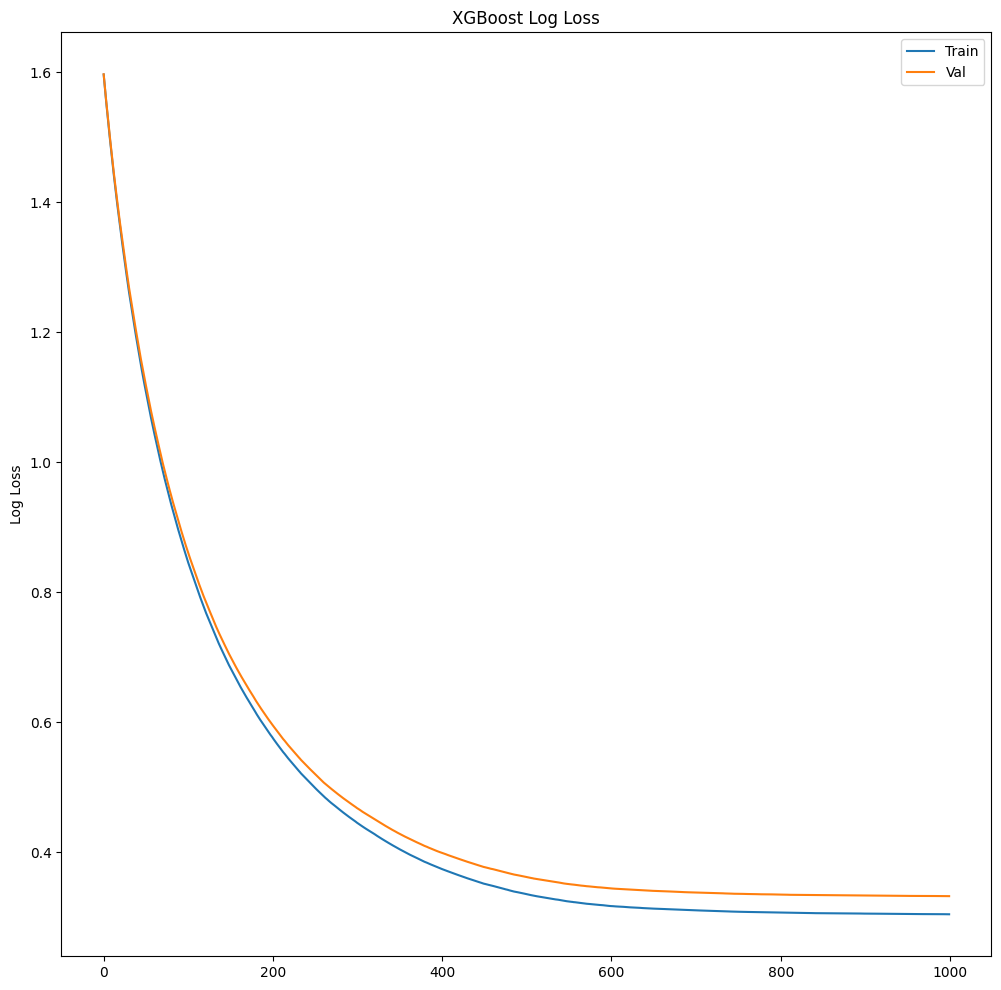

In [32]:
from matplotlib import pyplot as plot
%matplotlib inline

fig, ax = plot.subplots(figsize=(12,12))
ax.plot(results["validation_0"]["mlogloss"], label="Train")
ax.plot(results["validation_1"]["mlogloss"], label="Val")
ax.legend()
plot.ylabel("Log Loss")
plot.title("XGBoost Log Loss")
plot.show()

# plot.plot(results['validation_1']['merror'])
# plot.show()

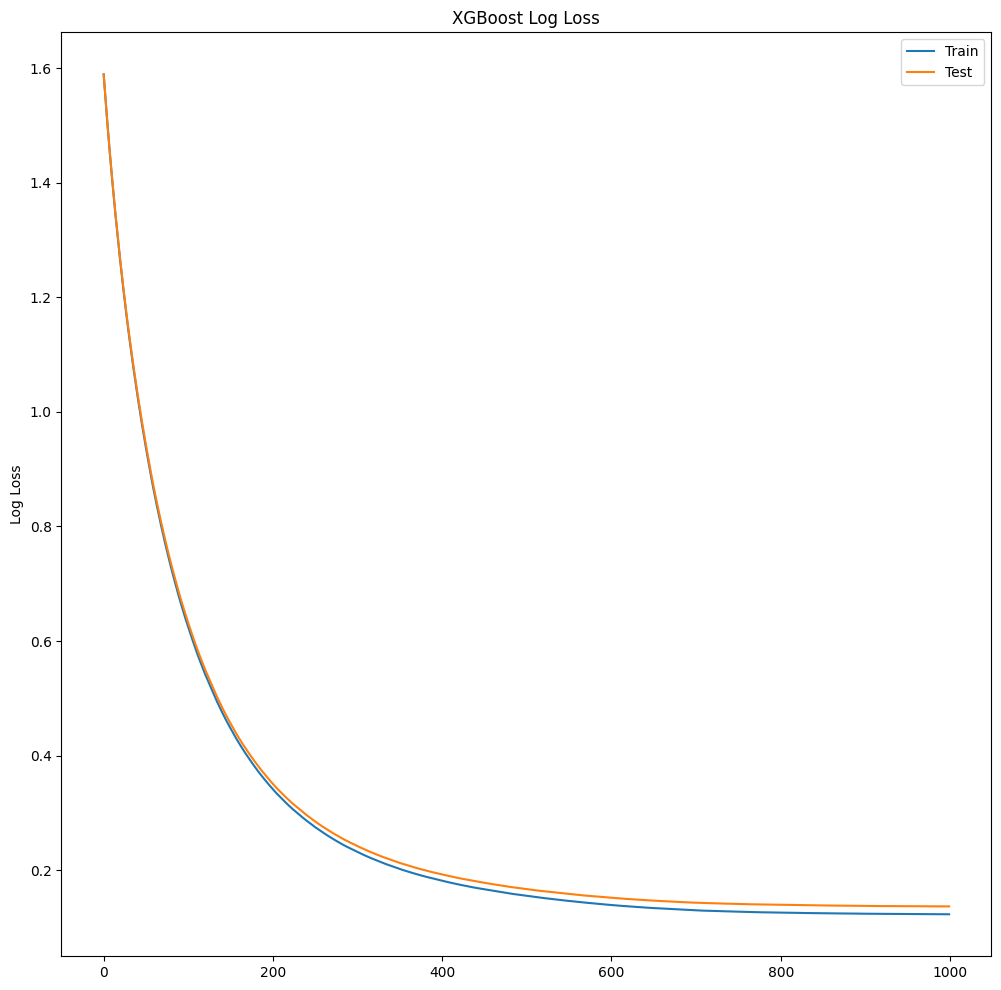

In [51]:
from matplotlib import pyplot as plot
%matplotlib inline

fig, ax = plot.subplots(figsize=(12,12))
ax.plot(results["validation_0"]["mlogloss"], label="Train")
ax.plot(results["validation_1"]["mlogloss"], label="Test")
ax.legend()
plot.ylabel("Log Loss")
plot.title("XGBoost Log Loss")
plot.show()

# plot.plot(results['validation_1']['merror'])
# plot.show()

In [33]:
from sklearn.metrics import accuracy_score
import time
# my_model.set_param({"predictor": "gpu_predictor"})
predictions = my_model.predict(test_x)

start = time.time()
y_pred  = my_model.predict(test_x)
print(time.time() - start)
accuracy = accuracy_score(test_y, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error : " + str(mean_absolute_error(predictions, test_y)))


0.6047983169555664
Accuracy: 86.18%
Mean Absolute Error : 0.31079105466340773


In [16]:
from sklearn.metrics import accuracy_score
import time
# my_model.set_param({"predictor": "gpu_predictor"})
# predictions = my_model.predict(test_x)

start = time.time()
y_pred  = my_model.predict(test_x)
print(time.time() - start)
accuracy = accuracy_score(test_y, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error : " + str(mean_absolute_error(predictions, test_y)))

0.8541617393493652
Accuracy: 90.13%
Mean Absolute Error : 0.2137081115654339


In [40]:
from xgboost import XGBClassifier
import time

model = XGBClassifier(silent=False,
                        scale_pos_weight=1,
                        learning_rate=0.01,
                        colsample_bytree = 0.4,
                        subsample = 0.8,
                        objective='binary:logistic',
                        n_estimators=1000,
                        reg_alpha = 0.3,
                        max_depth=4,
                        gamma=10,
                        n_jobs=5,
                        tree_method="gpu_hist")
                        # predictor="gpu_predictor")
model.load_model('xgb_ecg.model')
start = time.time()
y_pred  = model.predict(test_x)
print(time.time() - start)
# accuracy = accuracy_score(test_y, y_pred)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))

0.6148667335510254


In [39]:
from xgboost import XGBClassifier
import time

model = XGBClassifier(silent=False,
                        scale_pos_weight=1,
                        learning_rate=0.01,
                        colsample_bytree = 0.4,
                        subsample = 0.8,
                        objective='binary:logistic',
                        n_estimators=1000,
                        reg_alpha = 0.3,
                        max_depth=4,
                        gamma=10,
                        n_jobs=5,
                        tree_method="gpu_hist",
                        predictor="gpu_predictor")
model.load_model('xgb_ecg.model')
start = time.time()
y_pred  = model.predict(test_x)
print(time.time() - start)

0.8051068782806396
